# Outline

- setup
- running all transcribe + diarize pipelines and scoring them
- compiling and comparing results
- deep dive into error analysis
- misc information and discussion

# Setup


If you are running this locally after cloning the repo, make sure you first follow setup in `tinydiarize/README.md`, particularly the section on the fstalign scoring tool. This notebook handles the rest of the setup (including downloading eval data).

On Google Colab - this notebook will fetch and use pre-computed results until we figure out how to get the fstalign scoring tool working on Colab.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython import get_ipython
from IPython import display as ipd

In [2]:
# setup: we need to get tinydiarize files from git repo, install other dependencies, and fetch eval data for analysis
# update: google colab wont be possible as score.py uses docker to run fstalign which is not supported by colab
# so will have to use pre-computed results

if 'google.colab' in str(get_ipython()):
    # clone a particular branch of tinydiarize repo
    ! git clone https://github.com/akashmjn/tinyDiarize.git -b analysis-1 --single-branch
    # pip install
    ! pip install -e tinyDiarize
    # setup workdir
    WORKDIR = 'tinyDiarize/tinydiarize/workdir_analysis'
    CODEDIR = 'tinyDiarize/tinydiarize'
    _PRE_COMPUTED = True
else:
    # if running locally, assume that tinydiarize repo is already cloned and installed
    WORKDIR = '../workdir_analysis'
    CODEDIR = '..'
    _PRE_COMPUTED = False

ipd.clear_output()

# Evaluation data

We are using an out-of-distribution setup, evaluating on a different dataset than what the model was finetuned on (AMI meetings). As done in Whisper, this allows us to get a more realistic estimate of real-world generalization vs the model's ability to fit dataset-specific quirks of the AMI dataset.

For ease of analysis (and keeping with the 'tiny' spirit 😊), I've chosen a biased subset of 3 earnings calls from [rev/earnings21](https://github.com/revdotcom/speech-datasets/blob/main/earnings21/earnings21-file-metadata.csv). These were selected with the following criteria:
- One interactive Q&A meeting (*939, Hershey) with a higher rate of speaker switches and unique speakers
- One meeting (*910, Amex) that is moderated Q&A between only 2 speakers
- One meeting (*971, Constellium) that comprises both a presentation and Q&A session, and is somewhere in between

| file_id | audio_length | company_name | sector | speaker_switches | speaker_switches / minute | unique_speakers |
|---------|--------------|--------------|--------|------------------|---------------------------|-----------------|
| 4385939 | 3049.832     | Hershey Company | Consumer Goods | 132 | 2.60 | 19 |
| 4374910 | 2028.536     | American Express Company | Financial | 56 | 1.66 | 2 |
| 4359971 | 3759.944     | Constellium | Industrial Goods | 116 | 1.85 | 10 |

In [12]:
# setup workdir structure and fetch evaluation data

if _PRE_COMPUTED:
    # download pre-computed results from blob
    ! wget -O {CODEDIR}/workdir_analysis.tar.gz https://sharedstorage7190.blob.core.windows.net/tinydiarize/precomputed/workdir_analysis/5e09d4787a2674ea773547dcb9f23321a472bea883917337e0139a2ba0c2dd34.tar.gz
    # unpack pre-computed results into WORKDIR
    ! tar -xzf {CODEDIR}/workdir_analysis.tar.gz -C {CODEDIR}
else:
    ! mkdir -p {WORKDIR}
    # call a bash script with WORKDIR as an environment variable
    ! bash {CODEDIR}/scripts/fetch_earnings21_calls.sh {WORKDIR}

ipd.clear_output()

In [ ]:
# listen to an example file 
ipd.Audio(f'{WORKDIR}/audio/earnings21-4374910.mp3')

# Transcribing

We use a convenience script to transcribe and score the calls with a few different pipelines (explained in the following sections). This script runs both ASR and diarization components, scores them and parses detailed results into a single tsv file (done in `score.py`).

> *NOTE: On Google colab, we will fetch pre-computed results from my runs, as it's a bit tricky to setup the fstalign scoring tool*

In [ ]:
if not _PRE_COMPUTED:
    # change directory to ../scripts
    ! cd {CODEDIR}/scripts

    # process all the selected calls
    calls = [
        ("earnings21-4385939", 19),
        ("earnings21-4374910", 2),
        ("earnings21-4359971", 10),
    ]

    # iterate over calls and run the script run_pipelines.py
    for call_id, num_speakers in calls:
        ! python run_pipelines.py {WORKDIR}/audio/{call_id}.mp3 {WORKDIR}/fstalign_scoring/references/{call_id}-ref.nlp {WORKDIR}/transcripts/tiny.en/{call_id} --num_speakers {num_speakers}

    # change directory back to ../notebooks
    ! cd ./notebooks

# TODO@Akash - verify run_pipelines works, for now assuming that results are generated correctly

# Metrics

For our analysis, we use the following metrics:
- WER: word error rate as measured by `fstalign`
- Speaker turn recall: the fraction of speaker changes that are correctly identified
- Speaker turn precision: the fraction of predicted speaker changes that are correct

Just like WER, speaker turn recall and precision are computed by aligning reference and hypothesis transcripts, after inserting a special `speaker__turn` token, and then counting errors on the special tokens. This is done by `fstalign` as well.

Diarization typically uses either time-based metrics (e.g. DER measures fraction of time correctly attributed) or transcript-based metrics that compare the final recognized transcript. As the final goal of diarization is to produce a transcript, I prefer metrics that evaluate the final output. (with issues of disfluencies, speaker overlap, etc. best handled in the convention used to produce a readable transcript). 

I also find that transcript-based metrics are much more intuitive to understand, as we can easily analyze errors in the context of what was actually spoken i.e. [WYSIWYG](https://en.wikipedia.org/wiki/WYSIWYG). 

> (insert an example transcript, why WYSIWYG metric choice)

`TODO@Akash` - add a note that only measuring a sub-task of diarization 

# Compiling results

Before going into the results, here's a quick overview of the pipelines that were just run:
- `pyannote_pre_sr`: runs full pyannote diarization pipeline, and then whisper.transcribe on speaker-contiguous segments, retaining the speaker assignment
- `time_segment`: simple baseline that adds a speaker turn after every time segment created by whisper.transcribe
- `punctuation`: simple baseline that adds a speaker turn after every ending punctuation e.g. `.?!` created by whisper.transcribe
- `token`: tinyDiarize model that is finetuned to output a `speaker_turn` token along with words recognized in whisper.transcribe


In [3]:
# some utility functions 
%load_ext autoreload 
%autoreload 2
import sys
sys.path.append(CODEDIR)  # TODO@Akash - consider pip installing vs directly calling code files?
from analysis_utils import compile_results, query_metric_results, plot_metric_results

We now compile all the TSV files generated by `score.py` into a single dataframe for analysis. 

There is also a detailed error breakdown of each metric e.g. (DEL/INS/SUB) for WER, false positives (INS/SUB) and false negatives (DEL/SUB) for speaker turn recall and precision.

In [4]:
results_df, analysis_results = compile_results(f"{WORKDIR}/fstalign_scoring/results")
results_df.head()

Read 84 results from 21 files
Read 21 side-by-side analysis results


,metric,value,denominator,numerator,deletions,insertions,substitutions,result_id,model,call_id,method
0,wer_overall,7.498897,9068,680,83,228,369,small.en-ft_decoder-frz_bpe_time_2-hp2.pt__ear...,small.en-ft,4385939,token
1,wer_speaker_switch,11.422846,998,114,27,31,56,small.en-ft_decoder-frz_bpe_time_2-hp2.pt__ear...,small.en-ft,4385939,token
2,spk_turn_precision,98.958328,96,95,0,1,0,small.en-ft_decoder-frz_bpe_time_2-hp2.pt__ear...,small.en-ft,4385939,token
3,spk_turn_recall,72.519081,131,95,30,0,6,small.en-ft_decoder-frz_bpe_time_2-hp2.pt__ear...,small.en-ft,4385939,token
0,wer_overall,13.713123,4915,674,360,71,243,small.en__earnings21-4374910_drz_pre_sr__segment,small.en,4374910,pyannote_pre_sr


We summarize and compare the speaker turn recall and precision metrics for each pipeline below.

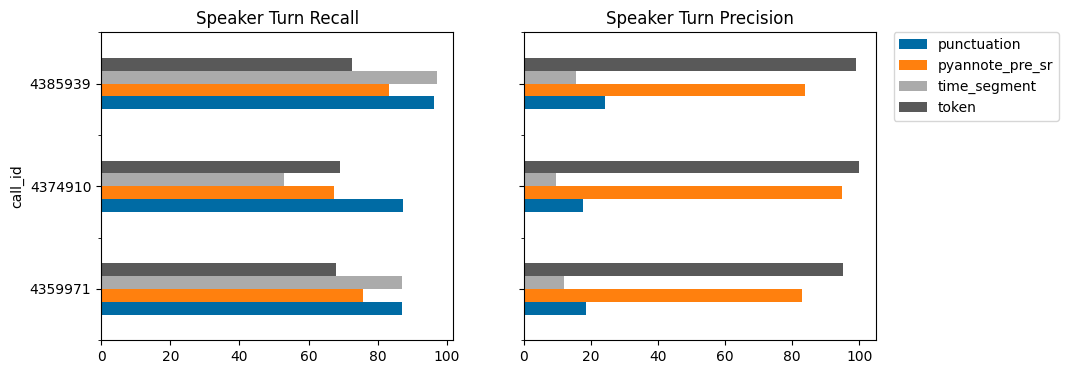

In [5]:
# comparing results for pyannote_pre_sr, time_segment, punctuation, token
subset_df = results_df.query('~(model=="small.en-ft" and method != "token")')
subset_df = subset_df.query('method not in ["time_segment_clustered"]')
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
d1 = query_metric_results(subset_df, "spk_turn_recall", groups=["call_id", "method"])
plot_metric_results(d1, title="Speaker Turn Recall", ax=axes[0], legend=False)
d2 = query_metric_results(subset_df, "spk_turn_precision", groups=["call_id", "method"])
plot_metric_results(d2, title="Speaker Turn Precision", ax=axes[1])

Here we look at Whisper models finetuned to detect speaker turns, partially solving the speaker-segmentation aspect of diarization. We want to see high accuracy with minimal impact on the WER.

We can make the following observations:
- `TODO@Akash` - add observations

ideally we want speaker turn tokens to improve on the precision of baseline punctuation, while retaining its high recall. 

baselines actually have quite good recall, better than existing diarization approaches, at no extra cost (tabulate the cost).

(suprising that diarization pipelines work the worst on a call with only two speakers, should look into it)

Very consistent performance. Finally, can look at a transcripts to get a better feel for what transcripts produced by ft-token look like 

need to look at side by side to properly understand the drawbacks/bottlnecks of diarization designs

# Error inspection

let's look at some examples to build intuition about what's going on 
* dive into `pre_sr` baseline errors
* diff with punctuation baseline
* diff with joint sr approach in `tinydiarize`

In [ ]:
# listen to an example file 
ipd.Audio(f'{WORKDIR}/audio/earnings21-4385939.mp3')

### Recall Errors (*939, *910)

When we look at errors from pyannote we can see that the errors tend to be around short, few-word segments.

In [66]:
model_id = "small.en"
call_id = "4385939"
method = "pyannote_pre_sr"
result_key = (model_id, call_id, method)

ipd.display(results_df.query(f'model=="{model_id}" and call_id=="{call_id}" and method=="{method}"').iloc[:, :7])

spk_turn_errors = analysis_results[result_key]
print(f"Result key: {result_key}")
print(f"Precision errors: {len(spk_turn_errors['precision_errors'])}")
print(f"Recall errors: {len(spk_turn_errors['recall_errors'])}")

,metric,value,denominator,numerator,deletions,insertions,substitutions
0,wer_overall,14.317279,9052,1296,606,174,516
1,wer_speaker_switch,24.849699,998,248,69,63,116
2,spk_turn_precision,83.846153,130,109,0,18,3
3,spk_turn_recall,83.206108,131,109,16,0,6


Result key: ('small.en', '4385939', 'pyannote_pre_sr')
Precision errors: 21
Recall errors: 16


In [94]:
# notes on recall errors:
# 0,3,4,6,7,9,10,11,13,14  - ASR deleted backchannel; 
# 1,2,5,8,12,15  - valid short segment recall errors;
i = 15 
print("Line:", spk_turn_errors["recall_errors"][i]["line"])
print(spk_turn_errors["recall_errors"][i]["context"])

Line: 9295
                  it	it                  			
              thanks	thanks              			
                stay	stay                			
                well	well                			
       speaker__turn	speaker__turn       		___127_SPEAKER_TURN___	###127_###|
               <ins>	stay                	ERR		
               <ins>	quiet               	ERR		
               <ins>	speaker__turn       	ERR		
               thank	thank               			
                 you	you                 			
       speaker__turn	<del>               	ERR	___128_SPEAKER_TURN___	###128_###|
               thank	thank               			
                 you	you                 			
              ladies	ladies              			
                 and	and                 			
           gentlemen	gentlemen           			
                that	that                			
           concludes	concludes           			
                 our	our                 			
            question	question            			


In [ ]:
model_id = "small.en"
call_id = "4374910"
method = "pyannote_pre_sr"
result_key = (model_id, call_id, method)

spk_turn_errors = analysis_results[result_key]
print(f"Result key: {result_key}")
print(f"Precision errors: {len(spk_turn_errors['precision_errors'])}")
print(f"Recall errors: {len(spk_turn_errors['recall_errors'])}")

Result key: ('small.en', '4374910', 'pyannote_pre_sr')
Precision errors: 2
Recall errors: 17


In [ ]:
# notes on recall errors: 
# 0,1 - invalid laughter; 
# 2,3,4,5,6,11,12 - ASR deleted backchannel; 
# 7,8,9,10,13,14,15,16 - valid short segment recall errors;
i = 15
print("Line:", spk_turn_errors["recall_errors"][i]["line"])
print(spk_turn_errors["recall_errors"][i]["context"])

Line: 5036
               right	right               			
                 you	you                 			
                 too	two                 	ERR		
               craig	great               	ERR		
               great	great               			
                  to	to                  			
                 see	see                 			
                 you	you                 			
               thank	thank               			
                 you	you                 			
       speaker__turn	<del>               	ERR	___53_SPEAKER_TURN___	###53_###|
              thanks	thanks              			
                take	take                			
                care	care                			
                doug	doug                			
       speaker__turn	<del>               	ERR	___54_SPEAKER_TURN___	###54_###|
                 all	<del>               	ERR		
               right	bye                 	ERR		
                 bye	bye                 			
------------------------------------------------------

`TODO@Akash` go through the recall errors of `punctuation` after this as a comparison

*If we look at the few speaker turns that were missed, these mainly because whisper chose to ignore those words (SR error). For the words actually recognized, the model almost always (>90-95%) distinguishes different speakers. Confirms that is has a useful internal representation.*

### Precision errors (*939)

Here too we see errors involving oversegmentation of short segments. Either falsely assigning a short segment to a new speaker, or falsely creating overlapped segments.

`TODO@Akash` go through the precision errors of `token` after this as a comparison

In [97]:
# notes on precision errors:
# 0 - pyannote false positive short segment, not transcribed;
# 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19 - oversegmented short segments with false speaker turns;
# 20 - duplicated overlapped section
for i in range(len(spk_turn_errors["precision_errors"])):
    print(f"\n\nError index: {i}, line: {spk_turn_errors['precision_errors'][i]['line']}")
    print(spk_turn_errors["precision_errors"][i]["context"])



Error index: 0, line: 3239
                able	able                			
                  to	to                  			
                 put	put                 			
             holiday	holiday             			
                  on	on                  			
                 the	the                 			
               floor	floor               			
       speaker__turn	speaker__turn       		___39_SPEAKER_TURN___	###39_###|
               <ins>	the                 	ERR		
               <ins>	cross               	ERR		
               <ins>	speaker__turn       	ERR		
                okay	okay                			
              thanks	thanks              			
                  so	so                  			
                much	much                			
                 for	for                 			
                 the	the                 			
               color	color               			
               there	there               			
       speaker__turn	speaker__turn       		___40_SPEAKER_TURN___	###40_###|


`TODO@Akash` go through the precision errors of `token` after this as a comparison

The model already separates different speakers using punctuations very reliably, with high recall. 

This confirms the hypothesis that time resolution is clearly a limitation of indepedent pre-sr pipelines.

> TODO@Akash - enable diff between errors
> TODO@Akash - attempt to breakdown the misses from SR DELs vs misses in diarization

todos: 
- change line number to reference word number
- make into class that stores original lines, configurable context 
- make a neat side-by-side fixed width print
- compare pre_sr and punctuation results 

# Misc 

- comparison of WER from pre_sr segmentation and after finetuning
- comparison of runtime between pyannote, tinydiarize and time_segment_clustered
- discussion of integration with clustering via post_sr results

### WER comparison and impact of fine-tuning

We can see that naively altering the segments in `drz_pre_sr` can have a significant (15%+ relative) negative impact on the WER. In regions around speaker switches the impact is much higher (40-70%), as segments tend to be much shorter here.

In [ ]:
subset_df = results_df.query('method in ["pyannote_pre_sr", "time_segment"]')
print("WER impact of finetuning")
ipd.display(query_metric_results(subset_df.query('method=="time_segment"'), "wer_overall", groups=["call_id", "model"]))
# we see that after finetuning, the overall WER not impacted too much
print("WER impact of segmentation in pyannote_pre_sr")
ipd.display(query_metric_results(subset_df, "wer_overall", groups=["call_id", "method"]))
# ipd.display(query_metric_results(subset_df, "wer_speaker_switch", groups=["call_id", "method"]))
# pre-segmented recognition hurts WER, especially around speaker switches

WER impact of finetuning


model,small.en,small.en-ft
call_id,,
4359971,13.03,13.89
4374910,10.14,6.91
4385939,10.18,7.50


WER impact of segmentation in pyannote_pre_sr


method,pyannote_pre_sr,time_segment
call_id,,
4359971,19.58,13.03
4374910,13.71,6.91
4385939,14.32,7.50


I've also noticed these undesirable regressions/gotchas. The regressions are fixable with more modular and careful finetuning.
- the finetuned model spkturn_segments has significantly lower recall from ~ 80% -> 10%. probably because of training on a different (longer) distribution of segments in ami data. or that the model simply forgets to output timestamps
- WER is quite different, some better or worse, with very different sub/ins/del pattern

### Runtime comparison

### Discussion on adding clustering

`TODO@Akash` - clean up rough notes here 

how to retain advantages?

looking closer we see why (insert nemo graphic on fidelity vs temporal resolution). this tradeoff comes at a significant extra cost (already quite expensive). even so, it is a patch on a fundamental drawback. SR models can easiliy output tokens at much higher time resolution, making it a much more natural choice. 
this will only yield local (within 30s chunk) - will still need a clustering process to group speakers across full timescale of meeting.

- gap in recall between drz_post_sr and segment            (indicates ?)
- gap in precision errors for post sr on 9971 inspite of higher recall?  (indicates clustering errors)

overall, the gap between segment and drz_post_sr shows a lot of clustering errors. 

Summary:
- the model makes very few spk turn predictions but with ~100% precision. these are likely already included within punctuations (should check if these were missed by time segments, or diarization)
- `drz_post_sr` clustering will still be needed. hope is that `speaker_turn` is predicted well difficult parts (short segments) acting in a complementary way to further improve clustering recall errors. to enable `drz_post_sr`, i need to modify decoding to force sample a timestamp when token is predicted
- since the model tends to be very precise, another `speaker_same` token could also help clustering precision errors, so that short segments still get assigned to the same speaker when there are larger # of speakers. in this case we'd skip sampling a timestamp to make a longer segment